# Analysis of the autism data

EDIT: This notebook is kept within the code package (1) for reviewers of the manuscript submitted to Nature Medicine in April 2023.
(1) It is mostly out of completeness that this notebook is included, but is mostly exploratory and did not lead to any precise results and/or numbers presented in the paper. In other words, the founding of this notebook has to be taken with a inch of salt. :-)



In [430]:
run init.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Done.


# Dataset Illustration

In [431]:
df = pd.read_csv(AUTISM_DATA_PATH)
# Data definition
data = Dataset(df=df, 
               missing_data_handling='encoding',
               imputation_method='without',
               sampling_method='without',
               scenario = 'papers', 
               features_name = DEFAULT_PREDICTORS,
               scale_data=True, 
               use_missing_indicator_variables=False,
               verbosity=4, 
               proportion_train=1)

Post-processing inital df (removing columns with no cva features, encoding srings, compute administrations order, compute condensed S/NS variables)... 
Removing 2400/2897 keeping only subject in studies: ['ARC', 'P1'].
Removing 12/497 keeping first admin.
Removing 26/485 keeping only subject with diagnosis: [0, 1].
459 administrations left.


,id
diagnosis,
0.0,416
1.0,43


Splitting dataset into test and train set.
Encoding 459 (train) and 0 (test) missing values with -5.
Predicting diagnosis based on 29 features
Splitting dataset into test and train set.
Encoding 459 (train) and 0 (test) missing values with -5.


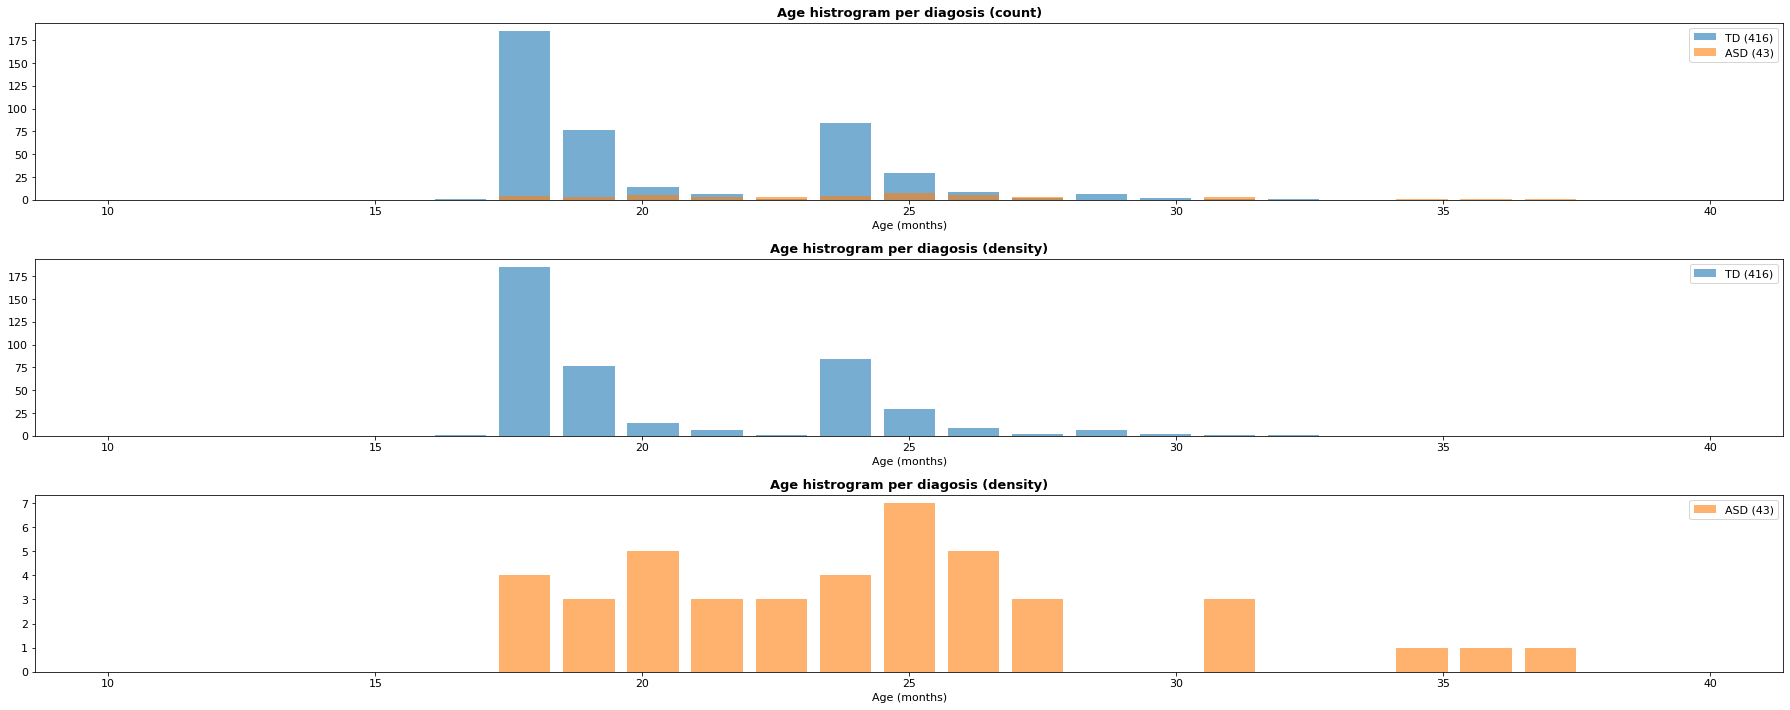

In [205]:
df=data.df
DIAG_DICT = {'TD':0., 
            'ASD':1., 
            'DDLD':2., 
            'ADHD':3.}
DIAG_DICT_REVERSE = {v: k for k, v in DIAG_DICT.items()}

colors = {'TD':'#1f77b4',
          'ASD': '#ff7f0e',
          'DDLD':'#2ca02c',
          'ADHD':'#d62728',
          'comorbid':'#9467bd'}

           
    
fig, axes = plt.subplots(3, 1, figsize=(25, 10)); axes=axes.flatten()

for i, d in df.groupby('diagnosis'):
    axes[0].hist(d['age'], bins=np.linspace(10, 40, 26), density=False, alpha=.6, rwidth=.8, color=colors[DIAG_DICT_REVERSE[i]], label="{} ({})".format(DIAG_DICT_REVERSE[i], len(d['age'])))
axes[0].legend(); axes[0].set_title("Age histrogram per diagosis (count)", weight='bold', fontsize=13); axes[0].set_xlabel("Age (months)")

for i, d in df.groupby('diagnosis'):
    axes[int(i+1)].hist(d['age'], bins=np.linspace(10, 40, 26), density=False, alpha=.6, rwidth=.8, color=colors[DIAG_DICT_REVERSE[i]], label="{} ({})".format(DIAG_DICT_REVERSE[i], len(d['age'])))
    axes[int(i+1)].legend(); axes[int(i+1)].set_title("Age histrogram per diagosis (density)", weight='bold', fontsize=13);axes[int(i+1)].set_xlabel("Age (months)")
plt.tight_layout()

In [214]:
for diag, d in df.groupby('diagnosis'):
    for sex, dd in d.groupby('sex'):
        print("Diagnosis: {} - Sex: {} : {}".format(diag, sex, len(dd)))

Diagnosis: 0.0 - Sex: 0.0 : 210
Diagnosis: 0.0 - Sex: 1.0 : 206
Diagnosis: 1.0 - Sex: 0.0 : 32
Diagnosis: 1.0 - Sex: 1.0 : 11


In [215]:
n_asd = 43
n_td = 416

print(32/43)
print(210/416)

0.7441860465116279
0.5048076923076923


In [217]:
43/459

0.09368191721132897

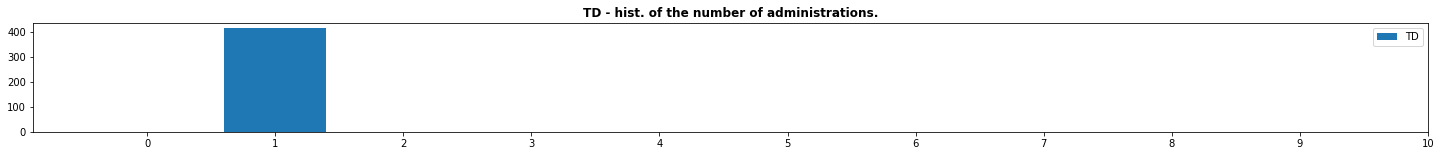

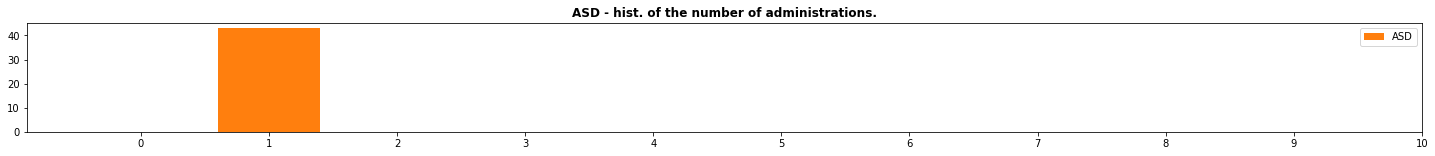

In [ ]:
for i, d in df.groupby('diagnosis'):
    plt.figure(figsize=(25, 2)), 
    plt.hist(d.groupby("id")['diagnosis'].count().to_numpy(), bins = np.linspace(0, 10 , 11), rwidth=.8,color=colors[DIAG_DICT_REVERSE[i]], label=DIAG_DICT_REVERSE[i])
    plt.xticks(ticks=np.linspace(0, 10 , 11)+.5, labels=np.linspace(0, 10 , 11).astype(int));plt.legend()
    plt.title("{} - hist. of the number of administrations.".format(DIAG_DICT_REVERSE[i]), weight='bold')

<AxesSubplot:title={'center':'Percentage of missing values per feature'}>

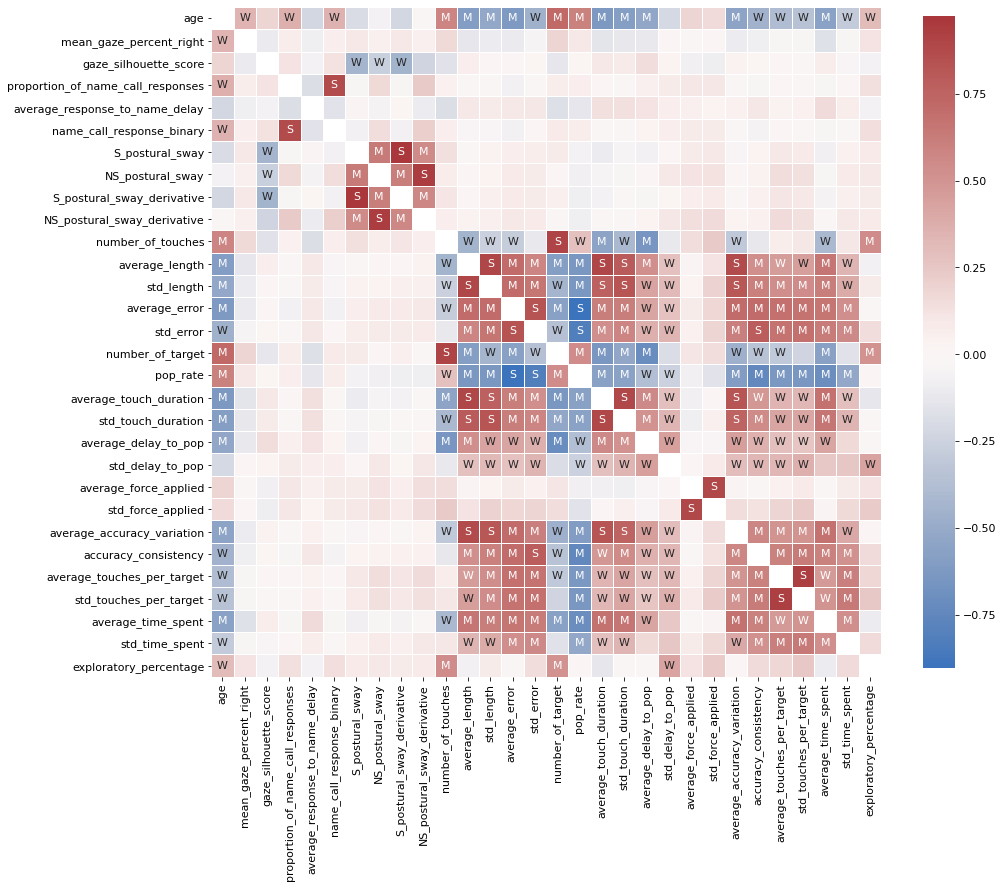

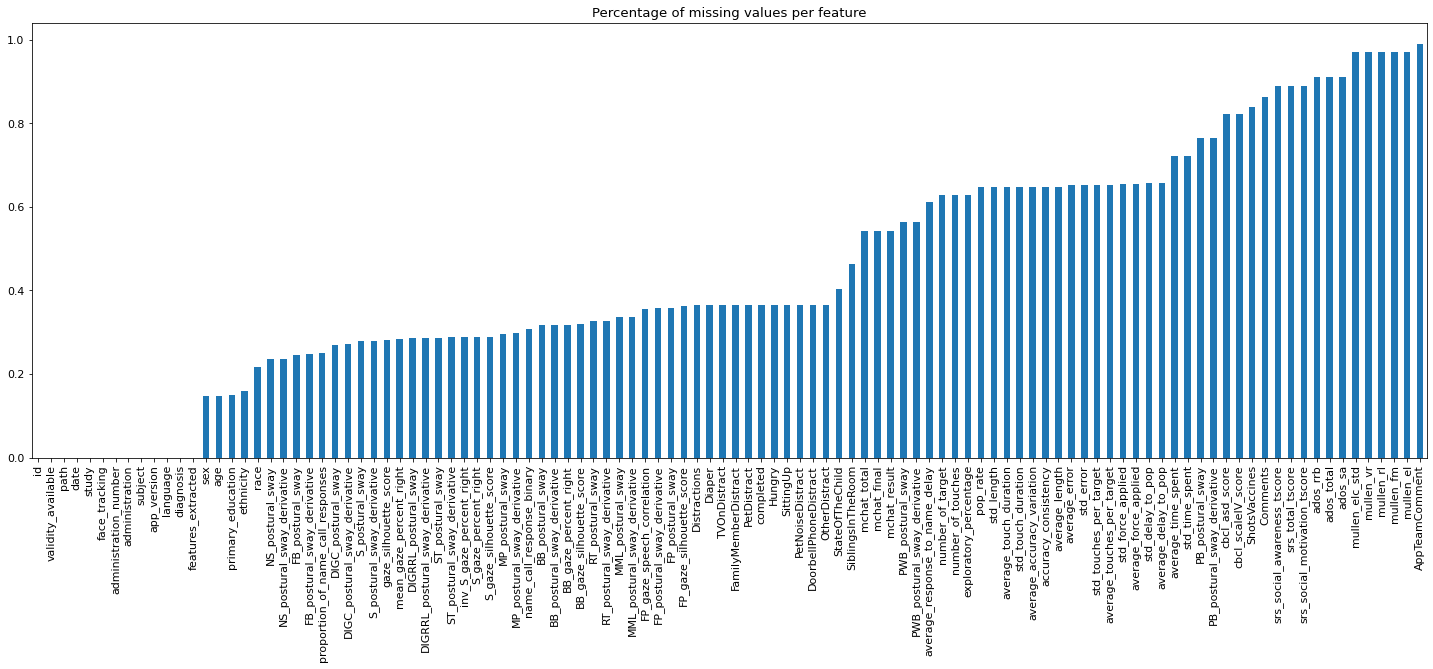

In [108]:
import missingno as msno
df_X = df[['age'] + data.features_name]


def custom_spearmanr(x, y):
    from scipy.stats import spearmanr
    return spearmanr(x, y, nan_policy='omit').correlation


# Computes feature correlation
df_corr = df_X.corr(method=custom_spearmanr)

labels = np.where(np.abs(df_corr)>0.75, "S",
                  np.where(np.abs(df_corr)>0.5, "M",
                           np.where(np.abs(df_corr)>0.25, "W", "")))

# Plot correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(df_corr, mask=np.eye(len(df_corr)), square=True,
            center=0, annot=labels, fmt='', linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.8});

plt.figure()
df.isna().mean().sort_values().plot(
    kind="bar", figsize=(25, 8),
    title="Percentage of missing values per feature")

In [17]:
df[df['diagnosis']==1].isna().mean()

id                             0.000000
diagnosis                      0.000000
language                       0.000000
app_version                    0.000000
subject                        0.000000
                                 ...   
S_postural_sway_derivative     0.069767
NS_postural_sway_derivative    0.000000
gaze_silhouette_score          0.069767
inv_S_gaze_percent_right       0.093023
mean_gaze_percent_right        0.093023
Length: 108, dtype: float64

<AxesSubplot:title={'center':'Difference of average missing data per columns ASD-NT (the lower, the more the feature is missing for the TD comapred to the ASD'}>

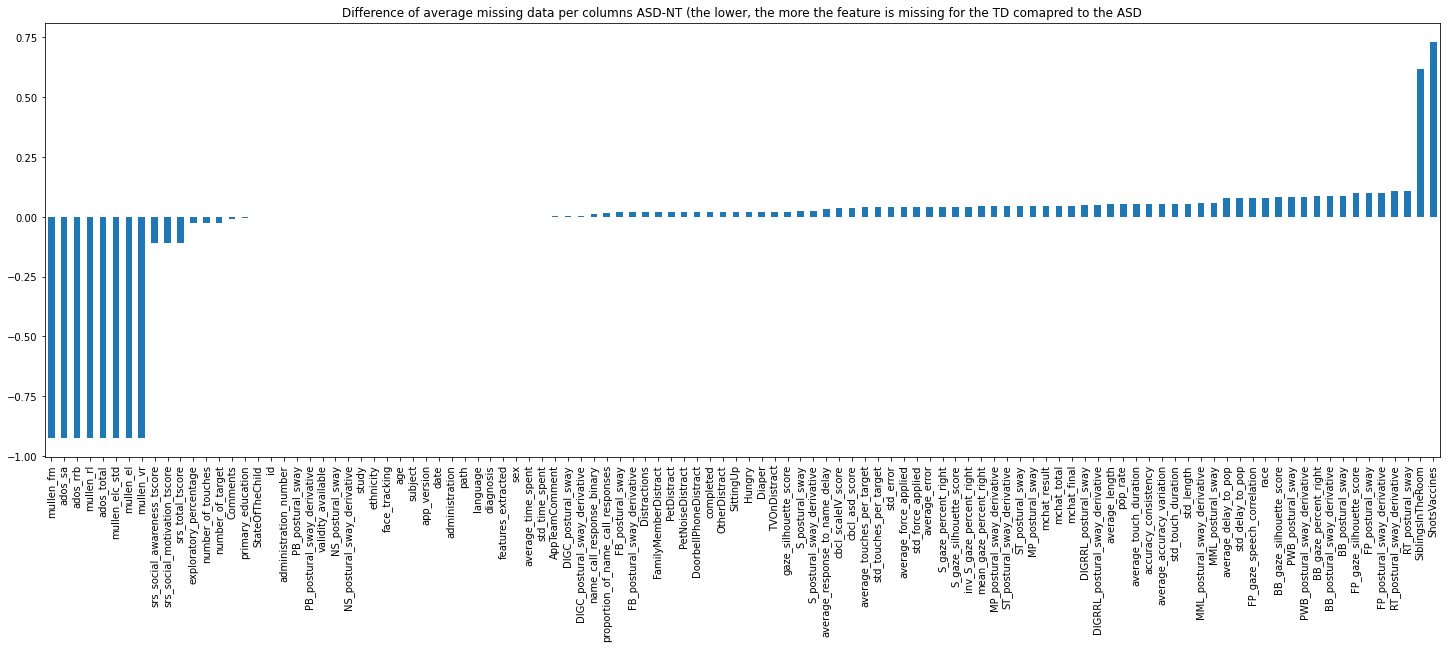

In [18]:
(df[df['diagnosis']==1].isna().mean() - df[df['diagnosis']==0].isna().mean()).sort_values().plot(
    kind="bar", figsize=(25, 8),
    title="Difference of average missing data per columns ASD-NT (the lower, the more the feature is missing for the TD comapred to the ASD")

In [19]:
df_X_asd = df[df['diagnosis']==1][data.features_name]
df_X_td = df[df['diagnosis']==0][data.features_name]

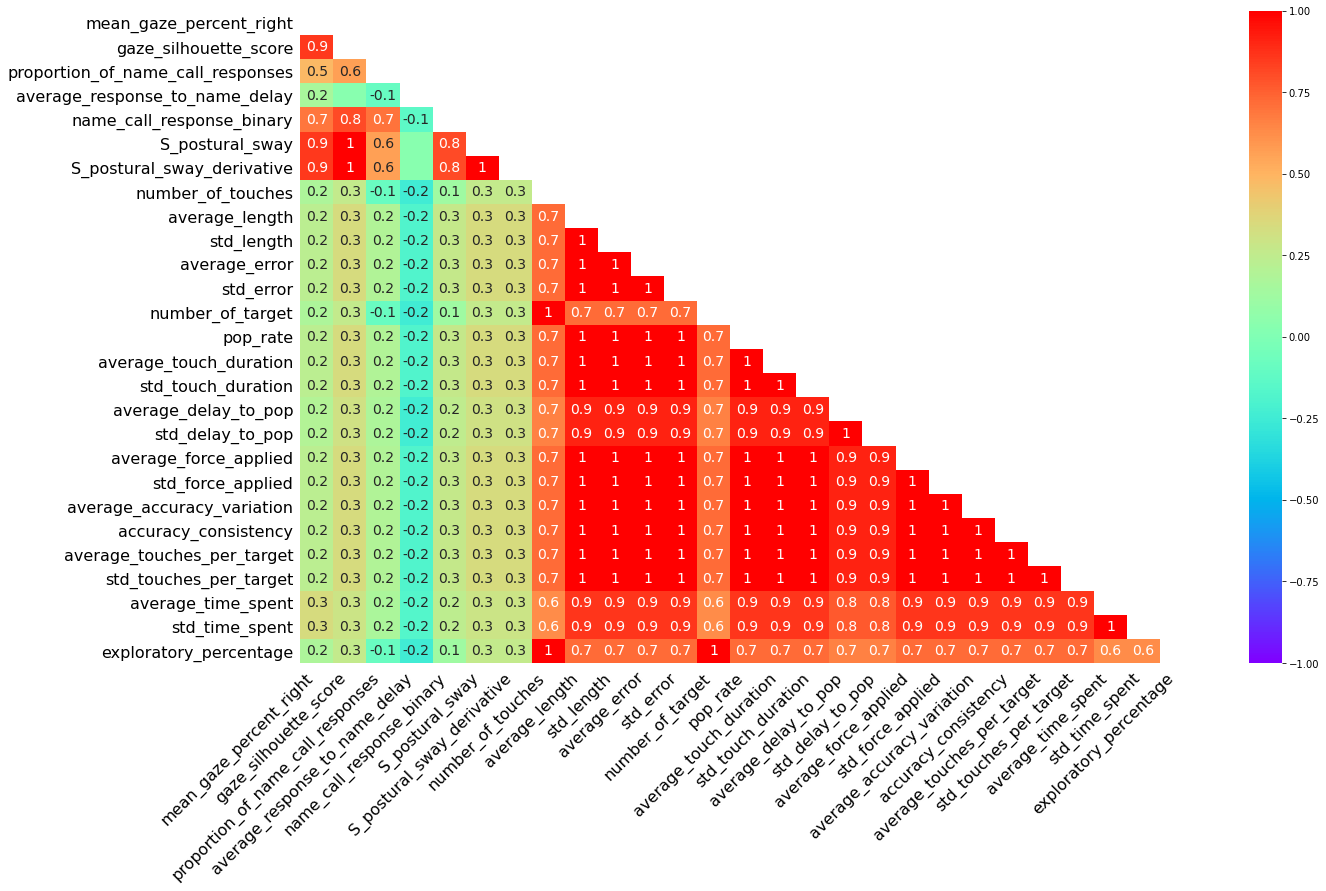

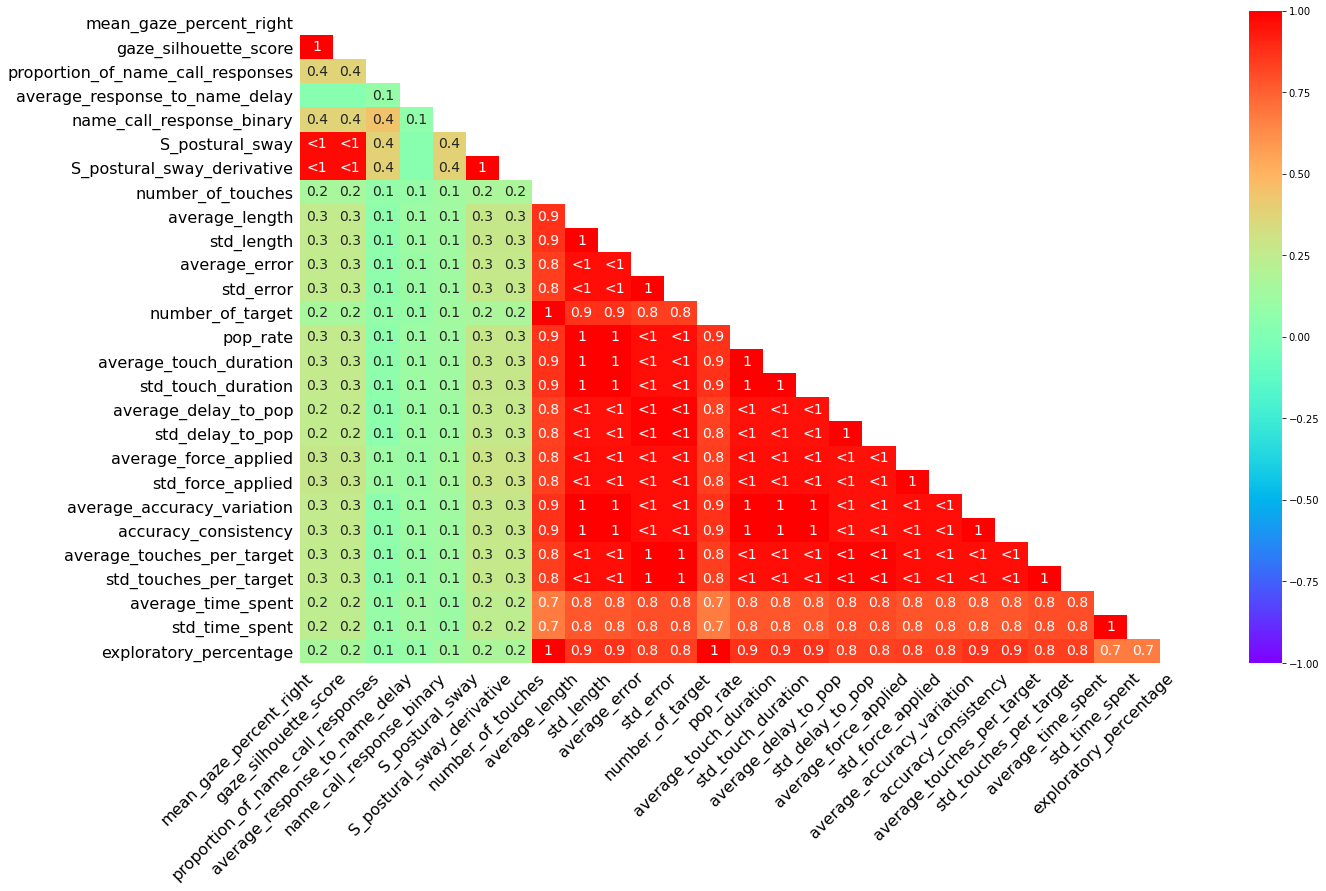

In [24]:
msno.heatmap(df_X_asd, cmap='rainbow');
msno.heatmap(df_X_td, cmap='rainbow');

In [211]:
#msno.dendrogram(df_X)

In [26]:
display(data.df.groupby('diagnosis')[['age', 'sex']].describe())

    
    

age                                                                                sex                                             
           count       mean       std        min        25%        50%        75%        max  count      mean       std  min  25%  50%  75%  max
diagnosis                                                                                                                                       
0.0        416.0  20.505202  3.134623  17.147541  18.098361  18.557377  24.000000  32.327869  416.0  0.495192  0.500579  0.0  0.0  0.0  1.0  1.0
1.0         43.0  24.265345  4.717926  18.065574  20.459016  24.000000  26.081967  36.852459   43.0  0.255814  0.441481  0.0  0.0  0.0  0.5  1.0

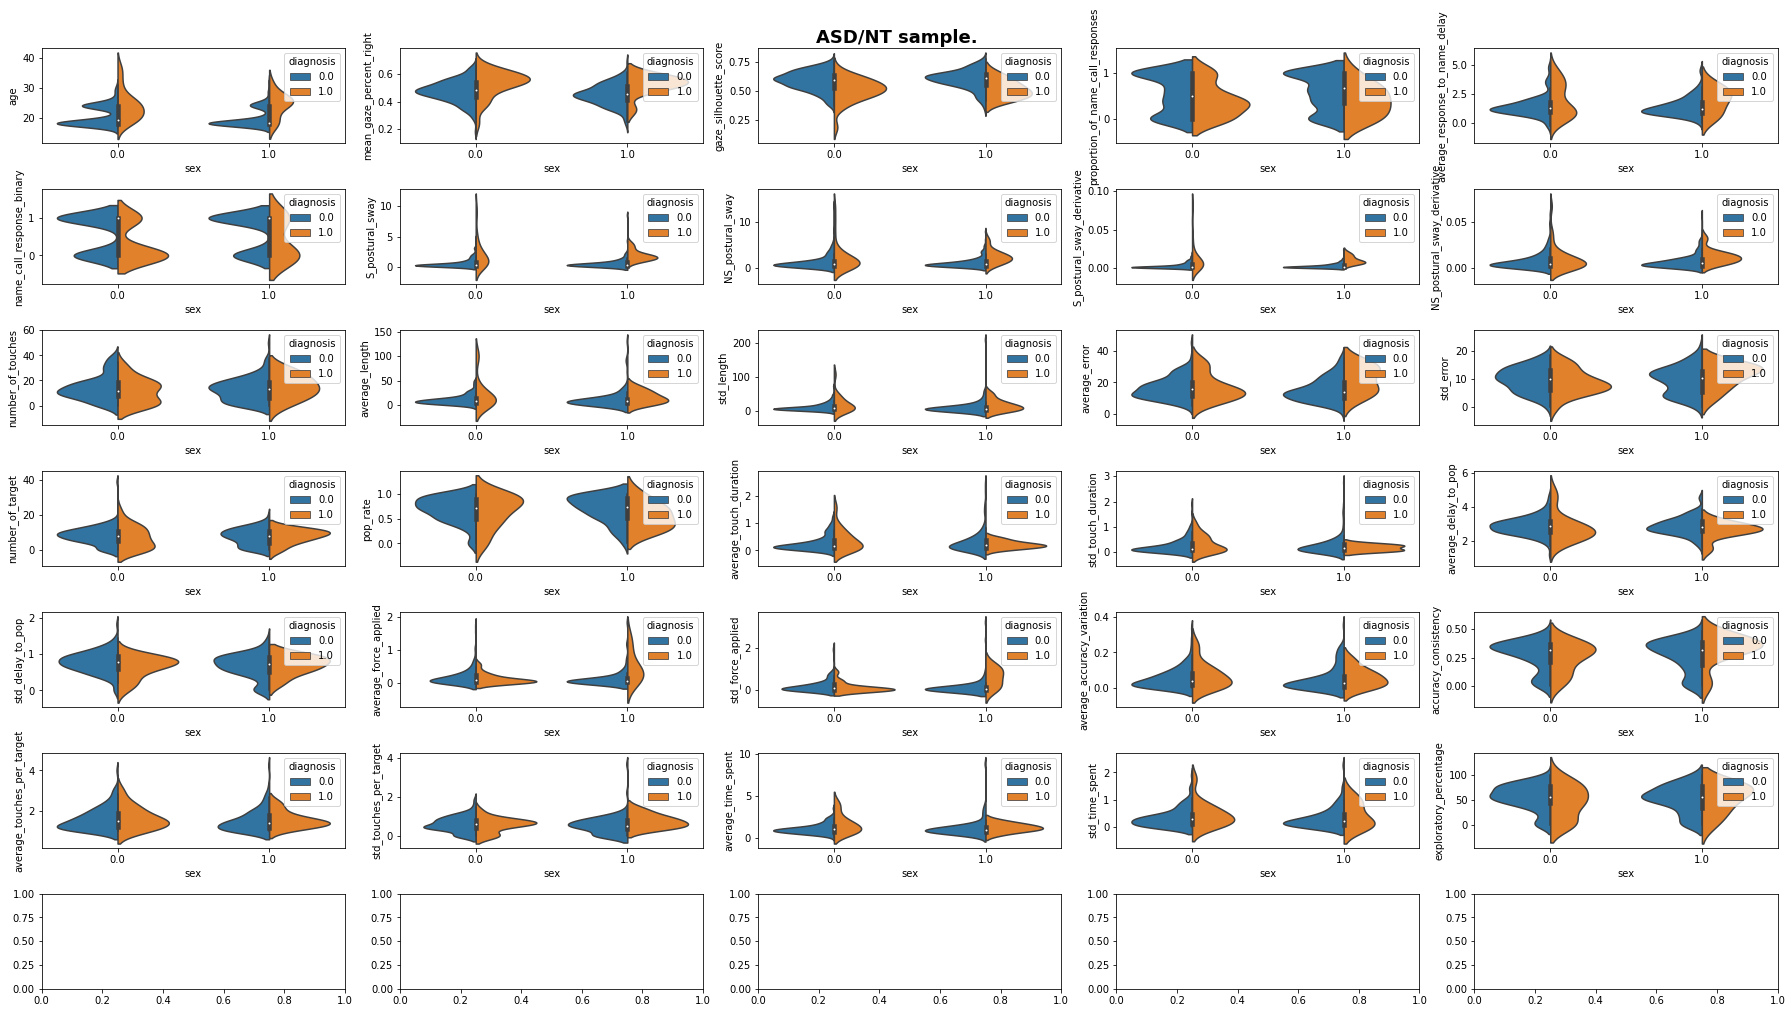

In [29]:
set_of_features  = {'asd_td_age_matched_n_balanced':["S_postural_sway", "mean_gaze_percent_right", "proportion_of_name_call_responses", "gaze_silhouette_score", "NS_postural_sway_derivative", "average_length"],
                    'asd_td_age_matched_n_unbalanced': ["S_postural_sway", "mean_gaze_percent_right", "NS_postural_sway", "proportion_of_name_call_responses", "NS_postural_sway_derivative", "gaze_silhouette_score"]}

selected_features = ['age'] + data.features_name



# Create a figure with 3 x 2 subplots
fig, axes = plt.subplots(ncols=5, nrows=len(selected_features)//5 +1, figsize=(25, 14))
fig.suptitle("ASD/NT sample.", weight='bold', fontsize=18)
# Loop through these features and plot entries from each feature against `Latitude`
for col, ax in zip(selected_features, axes.ravel()):
    sns.violinplot(data=data.df, y=col, x='sex', hue='diagnosis', palette="tab10",
                   split=True, ax=ax)
plt.tight_layout()

In [170]:
age_cutoff_list = np.linspace(36, 70, 70-36+1)
number_asd = []
number_td  =[]
age_mean_difference = []
for age in age_cutoff_list:
    df =  pd.read_csv(AUTISM_DATA_PATH)


    data = Dataset(df=df, 
                   missing_data_handling='without', 
                   imputation_method='without', 
                   sampling_method='without',
                   outcome_column='diagnosis',
                    features_name = DEFAULT_PREDICTORS, 
                    scale_data=False,
                    use_missing_indicator_variables=use_missing_indicator_variables,#grouped_missing_features,
                   verbosity=0,
                   scenario=None,#'papers',
                   proportion_train=1)


    data.filter(administration={'studies':  ['ARC', 'P1', 'P2', 'P3'],
                                            'order': 'first',
                                            'completed': True}, 
                               demographics={'age':[17, age]},
                                clinical={'diagnosis': [0, 1]},
                                verbose=False)

    number_asd.append(len(data.df[data.df['diagnosis']==1]))
    number_td.append(len(data.df[data.df['diagnosis']==0]))
    age_mean_difference.append(data.df[data.df['diagnosis']==1]['age'].mean() - data.df[data.df['diagnosis']==0]['age'].mean())

    

(array([ 2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

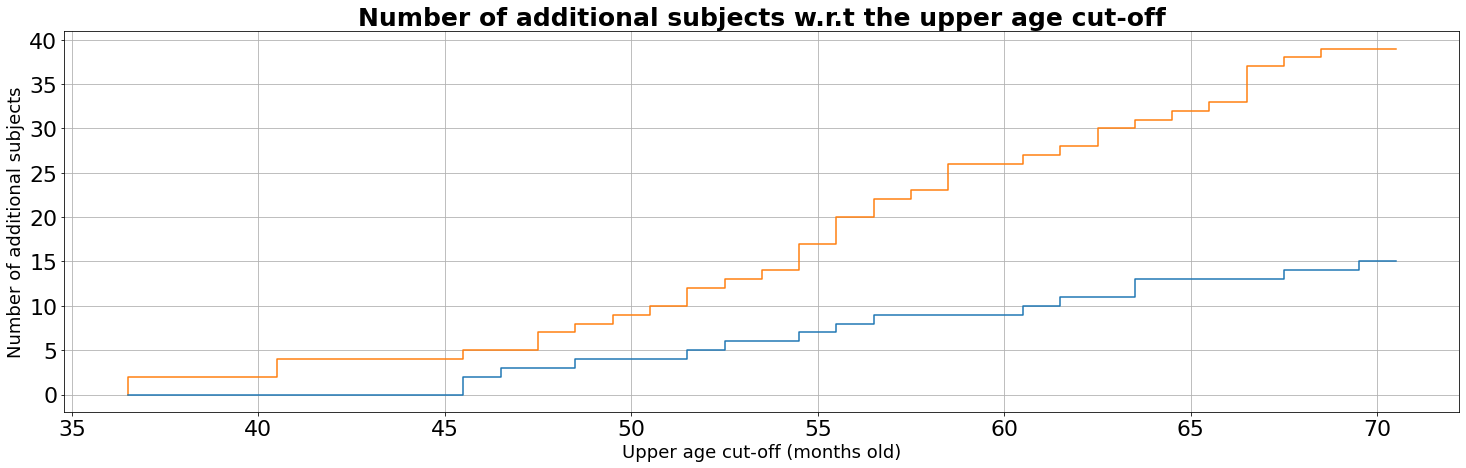

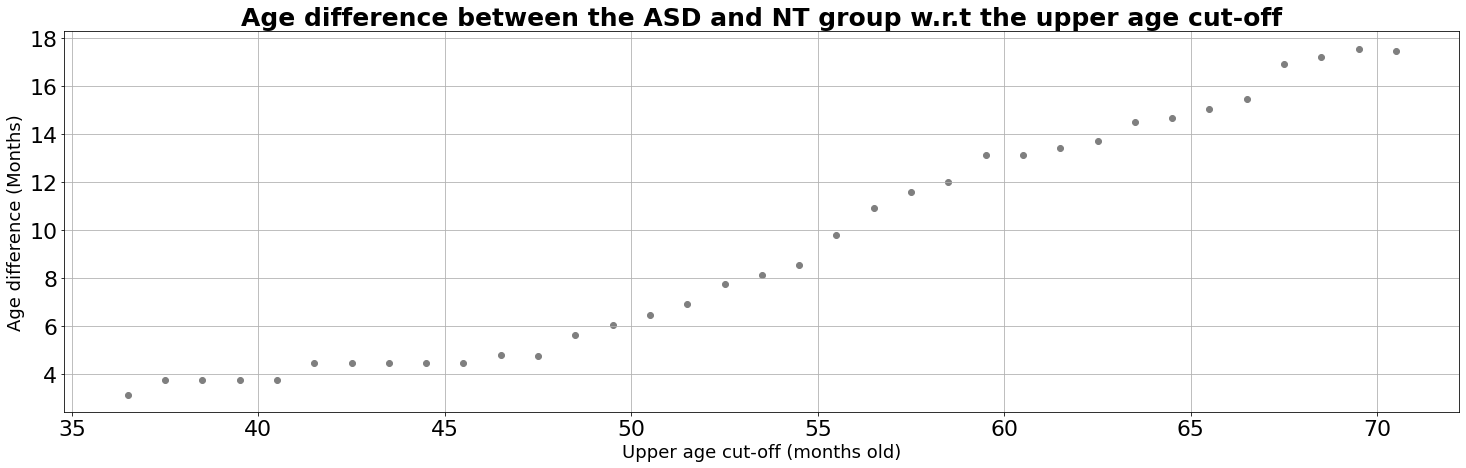

In [211]:
fi(25, 7)
plt.step(np.array(age_cutoff_list)+.5, np.array(number_asd)-number_asd[0], color='tab:orange')
plt.step(np.array(age_cutoff_list)+.5, np.array(number_td)-number_td[0], color='tab:blue')
plt.grid()
plt.title("Number of additional subjects w.r.t the upper age cut-off", weight='bold',fontsize=25)
plt.xlabel("Upper age cut-off (months old)",fontsize=18); plt.ylabel("Number of additional subjects",fontsize=18); 
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

fi(25, 7)
plt.title("Age difference between the ASD and NT group w.r.t the upper age cut-off", weight='bold',fontsize=25)
plt.scatter(np.array(age_cutoff_list)+.5, np.array(age_mean_difference), color='tab:gray')
plt.xlabel("Upper age cut-off (months old)",fontsize=18); plt.ylabel("Age difference (Months)",fontsize=18); 
plt.grid()

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)


In [154]:
df.sort_values(by='Sensitivity', ascending=False)

,dataset_name,experiment_number,approach,missing_data_handling,imputation_method,features_name,n_features,use_missing_indicator_variables,scale_data,sampling_method,scenario,num_samples,imbalance_ratio,ratio_of_missing_values,ratio_missing_per_class_0,ratio_missing_per_class_1,resolution,bandwidth,estimation_time,num_cv,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1,F1 score Corrected,Accuracy,MCC,Sensitivity,Specificity,Precision,PPV,NPV,FNR,FDR,FOR
54,paper_experiment_2_fs,14,ebm,encoding,constant,"['BB_gaze_percent_right', 'BB_gaze_silhouette_...",22,False,True,without,papers,459,0.093682,0.176273,0.172203,0.215645,20,0.2,22.843072,16,0.866,0.429,0.895,0.218,0.976,0.446,0.240,NaN,0.389,0.698,0.844,0.316,0.316,0.964,0.302,0.684,0.036
5,paper_experiment_1_fs,18,ebm,encoding,constant,"['BB_gaze_percent_right', 'BB_gaze_silhouette_...",22,False,True,without,papers,459,0.093682,0.176273,0.172203,0.215645,20,0.2,19.691246,16,0.866,0.429,0.895,0.218,0.976,0.446,0.240,NaN,0.389,0.698,0.844,0.316,0.316,0.964,0.302,0.684,0.036
53,paper_experiment_2_fs,19,ebm,encoding,constant,"['BB_gaze_percent_right', 'BB_gaze_silhouette_...",22,False,False,without,papers,459,0.093682,0.176273,0.172203,0.215645,20,0.2,21.703454,16,0.866,0.429,0.895,0.218,0.976,0.446,0.240,NaN,0.389,0.698,0.844,0.316,0.316,0.964,0.302,0.684,0.036
142,paper_experiment_4_fs,19,ebm,encoding,constant,"['BB_gaze_percent_right', 'BB_gaze_silhouette_...",22,False,True,without,papers,459,0.093682,0.176273,0.172203,0.215645,20,0.2,22.546902,16,0.866,0.429,0.895,0.218,0.976,0.446,0.240,NaN,0.389,0.698,0.844,0.316,0.316,0.964,0.302,0.684,0.036
74,paper_experiment_3_fs,49,ebm,imputation,mice,"['BB_gaze_percent_right', 'BB_gaze_silhouette_...",32,False,True,without,papers,459,0.093682,0.182870,0.178636,0.223837,20,0.2,23.948679,16,0.874,0.486,0.927,0.213,0.935,0.545,0.315,NaN,0.486,0.674,0.911,0.439,0.439,0.964,0.326,0.561,0.036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32,paper_experiment_2_fs,6,LogisticRegression,encoding,constant,"['mean_gaze_percent_right', 'BB_gaze_silhouett...",10,False,False,without,papers,459,0.093682,0.206100,0.200481,0.260465,20,0.2,0.471495,16,0.554,0.133,0.475,0.034,0.312,0.231,0.107,NaN,0.137,0.186,0.938,0.235,0.235,0.918,0.814,0.765,0.082
78,paper_experiment_3_fs,52,DecisionTree,imputation,knn,"['BB_gaze_percent_right', 'BB_gaze_silhouette_...",32,False,True,without,papers,459,0.093682,0.183279,0.179087,0.223837,20,0.2,0.070814,16,0.641,0.192,0.679,0.055,0.821,0.254,0.142,NaN,0.153,0.163,0.957,0.280,0.280,0.917,0.837,0.720,0.083
22,paper_experiment_1_fs,22,DecisionTree,encoding,constant,"['BB_gaze_percent_right', 'BB_gaze_silhouette_...",32,True,True,without,papers,459,0.093682,0.091639,0.089543,0.111919,20,0.2,0.055627,16,0.612,0.297,0.798,0.168,0.946,0.340,0.319,NaN,NaN,0.000,1.000,NaN,NaN,0.906,1.000,NaN,0.094
9,paper_experiment_1_fs,27,DecisionTree,encoding,constant,"['BB_gaze_percent_right', 'BB_gaze_silhouette_...",32,False,True,without,papers,459,0.093682,0.183279,0.179087,0.223837,20,0.2,0.051909,16,0.615,0.298,0.811,0.150,0.941,0.364,0.323,NaN,NaN,0.000,1.000,NaN,NaN,0.906,1.000,NaN,0.094


In [155]:
df.sort_values(by='Specificity', ascending=False)

,dataset_name,experiment_number,approach,missing_data_handling,imputation_method,features_name,n_features,use_missing_indicator_variables,scale_data,sampling_method,scenario,num_samples,imbalance_ratio,ratio_of_missing_values,ratio_missing_per_class_0,ratio_missing_per_class_1,resolution,bandwidth,estimation_time,num_cv,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1,F1 score Corrected,Accuracy,MCC,Sensitivity,Specificity,Precision,PPV,NPV,FNR,FDR,FOR
9,paper_experiment_1_fs,27,DecisionTree,encoding,constant,"['BB_gaze_percent_right', 'BB_gaze_silhouette_...",32,False,True,without,papers,459,0.093682,0.183279,0.179087,0.223837,20,0.2,0.051909,16,0.6150,0.2980,0.8110,0.1500,0.9410,0.3640,0.3230,NaN,NaN,0.0000,1.0000,NaN,NaN,0.9060,1.0000,NaN,0.0940
22,paper_experiment_1_fs,22,DecisionTree,encoding,constant,"['BB_gaze_percent_right', 'BB_gaze_silhouette_...",32,True,True,without,papers,459,0.093682,0.091639,0.089543,0.111919,20,0.2,0.055627,16,0.6120,0.2970,0.7980,0.1680,0.9460,0.3400,0.3190,NaN,NaN,0.0000,1.0000,NaN,NaN,0.9060,1.0000,NaN,0.0940
122,paper_experiment_4_fs,32,DecisionTree,encoding,constant,"['BB_gaze_percent_right', 'BB_gaze_silhouette_...",32,False,True,without,papers,459,0.093682,0.183279,0.179087,0.223837,20,0.2,0.057092,16,0.6150,0.2980,0.8110,0.1500,0.9410,0.3640,0.3230,NaN,NaN,0.0000,1.0000,NaN,NaN,0.9060,1.0000,NaN,0.0940
39,paper_experiment_2_fs,27,DecisionTree,encoding,constant,"['BB_gaze_percent_right', 'BB_gaze_silhouette_...",32,False,False,without,papers,459,0.093682,0.183279,0.179087,0.223837,20,0.2,0.052195,16,0.6150,0.3110,0.8180,0.1770,0.9500,0.3570,0.3190,NaN,0.3690,0.2090,0.9930,0.7500,0.7500,0.9240,0.7910,0.2500,0.0760
52,paper_experiment_2_fs,22,DecisionTree,encoding,constant,"['BB_gaze_percent_right', 'BB_gaze_silhouette_...",32,False,True,without,papers,459,0.093682,0.183279,0.179087,0.223837,20,0.2,0.063038,16,0.6150,0.3110,0.8180,0.1770,0.9500,0.3570,0.3190,NaN,0.3690,0.2090,0.9930,0.7500,0.7500,0.9240,0.7910,0.2500,0.0760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54,paper_experiment_2_fs,14,ebm,encoding,constant,"['BB_gaze_percent_right', 'BB_gaze_silhouette_...",22,False,True,without,papers,459,0.093682,0.176273,0.172203,0.215645,20,0.2,22.843072,16,0.8660,0.4290,0.8950,0.2180,0.9760,0.4460,0.2400,NaN,0.3890,0.6980,0.8440,0.3160,0.3160,0.9640,0.3020,0.6840,0.0360
5,paper_experiment_1_fs,18,ebm,encoding,constant,"['BB_gaze_percent_right', 'BB_gaze_silhouette_...",22,False,True,without,papers,459,0.093682,0.176273,0.172203,0.215645,20,0.2,19.691246,16,0.8660,0.4290,0.8950,0.2180,0.9760,0.4460,0.2400,NaN,0.3890,0.6980,0.8440,0.3160,0.3160,0.9640,0.3020,0.6840,0.0360
46,paper_experiment_2_fs,28,nam,encoding,constant,"['BB_gaze_percent_right', 'BB_gaze_silhouette_...",32,False,False,without,papers,459,0.093682,0.182870,0.178636,0.223837,20,0.2,1768.658187,16,0.7824,0.2815,0.7835,0.0970,0.7790,0.3622,0.1731,NaN,0.2900,0.5487,0.8390,0.2777,0.2777,0.9487,0.4513,0.7223,0.0513
35,paper_experiment_2_fs,18,nam,encoding,constant,"['BB_gaze_percent_right', 'BB_gaze_silhouette_...",22,False,False,without,papers,459,0.093682,0.176273,0.172203,0.215645,20,0.2,3186.954427,16,0.8051,0.3097,0.8272,0.1065,0.8105,0.3814,0.2052,NaN,0.3149,0.5884,0.8363,0.2904,0.2904,0.9528,0.4116,0.7096,0.0472


In [160]:
df.sort_values(by='AUROC', ascending=False)

,dataset_name,experiment_number,approach,missing_data_handling,imputation_method,features_name,n_features,use_missing_indicator_variables,scale_data,sampling_method,scenario,num_samples,imbalance_ratio,ratio_of_missing_values,ratio_missing_per_class_0,ratio_missing_per_class_1,resolution,bandwidth,estimation_time,num_cv,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1,F1 score Corrected,Accuracy,MCC,Sensitivity,Specificity,Precision,PPV,NPV,FNR,FDR,FOR
67,paper_experiment_3_fs,13,nam,imputation,knn,"['mean_gaze_percent_right', 'BB_gaze_silhouett...",10,False,True,without,papers,459,0.093682,0.202179,0.198558,0.237209,20,0.2,780.265721,16,0.8785,0.4666,0.9175,0.1994,0.9186,0.5225,0.3133,NaN,0.4565,0.5511,0.935,0.4803,0.4803,0.953,0.4489,0.5197,0.047
94,paper_experiment_3_fs,29,ebm,imputation,mice,"['BB_gaze_percent_right', 'BB_gaze_silhouette_...",22,False,True,without,papers,459,0.093682,0.176273,0.172203,0.215645,20,0.2,19.890506,16,0.8770,0.4100,0.8910,0.1580,0.7720,0.4670,0.2790,NaN,0.3910,0.4650,0.938,0.4350,0.4350,0.944,0.5350,0.5650,0.056
74,paper_experiment_3_fs,49,ebm,imputation,mice,"['BB_gaze_percent_right', 'BB_gaze_silhouette_...",32,False,True,without,papers,459,0.093682,0.182870,0.178636,0.223837,20,0.2,23.948679,16,0.8740,0.4860,0.9270,0.2130,0.9350,0.5450,0.3150,NaN,0.4860,0.6740,0.911,0.4390,0.4390,0.964,0.3260,0.5610,0.036
99,paper_experiment_3_fs,54,ebm,imputation,knn,"['BB_gaze_percent_right', 'BB_gaze_silhouette_...",32,False,True,without,papers,459,0.093682,0.182870,0.178636,0.223837,20,0.2,26.301447,16,0.8720,0.4930,0.9180,0.2240,0.9600,0.5520,0.3550,NaN,0.4870,0.5350,0.952,0.5350,0.5350,0.952,0.4650,0.4650,0.048
114,paper_experiment_4_fs,45,xgboost,encoding,constant,"['BB_gaze_percent_right', 'BB_gaze_silhouette_...",32,False,True,smote,papers,459,0.093682,0.183279,0.179087,0.223837,20,0.2,104.501504,16,0.8710,0.4240,0.8990,0.1710,0.9290,0.4590,0.2300,NaN,0.3920,0.6280,0.877,0.3460,0.3460,0.958,0.3720,0.6540,0.042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,paper_experiment_4_fs,17,DecisionTree,encoding,constant,"['BB_gaze_percent_right', 'gaze_silhouette_sco...",22,False,True,without,papers,459,0.093682,0.175777,0.172094,0.211416,20,0.2,0.045091,16,0.6070,0.3110,0.8260,0.1630,0.9510,0.3370,0.2890,NaN,0.2270,0.3490,0.904,0.2730,0.2730,0.931,0.6510,0.7270,0.069
50,paper_experiment_2_fs,12,DecisionTree,encoding,constant,"['BB_gaze_percent_right', 'gaze_silhouette_sco...",22,False,True,without,papers,459,0.093682,0.175777,0.172094,0.211416,20,0.2,0.047102,16,0.6050,0.3060,0.8250,0.1450,0.9430,0.3390,0.2960,NaN,0.3340,0.2090,0.988,0.6430,0.6430,0.924,0.7910,0.3570,0.076
37,paper_experiment_2_fs,17,DecisionTree,encoding,constant,"['BB_gaze_percent_right', 'gaze_silhouette_sco...",22,False,False,without,papers,459,0.093682,0.175777,0.172094,0.211416,20,0.2,0.044752,16,0.6050,0.3060,0.8250,0.1450,0.9430,0.3390,0.2960,NaN,0.3340,0.2090,0.988,0.6430,0.6430,0.924,0.7910,0.3570,0.076
20,paper_experiment_1_fs,12,DecisionTree,encoding,constant,"['BB_gaze_percent_right', 'gaze_silhouette_sco...",22,True,True,without,papers,459,0.093682,0.087889,0.086047,0.105708,20,0.2,0.049412,16,0.6030,0.2620,0.7940,0.0980,0.9190,0.3330,0.2210,NaN,0.2230,0.3490,0.901,0.2680,0.2680,0.931,0.6510,0.7320,0.069


In [158]:
(df['Specificity'] + df['Sensitivity']).sort_values()

122    1.000
22     1.000
9      1.000
78     1.120
32     1.124
       ...  
53     1.542
5      1.542
54     1.542
76     1.546
74     1.585
Length: 153, dtype: float64

In [159]:
df.iloc[74]

dataset_name                                                   paper_experiment_3_fs
experiment_number                                                                 49
approach                                                                         ebm
missing_data_handling                                                     imputation
imputation_method                                                               mice
features_name                      ['BB_gaze_percent_right', 'BB_gaze_silhouette_...
n_features                                                                        32
use_missing_indicator_variables                                                False
scale_data                                                                      True
sampling_method                                                              without
scenario                                                                      papers
num_samples                                                      